In [524]:
import numpy as np 
import random
import bisect
from matplotlib import pyplot as plt
from tqdm import tqdm

In [29]:
def readJSSP(path):
    with open(path, 'r') as f:
        lines =  f.readlines()
        jobs = [[(int(machine), int(cost)) for machine, cost in zip(line.split()[0::2], line.split()[1::2])]
                for line in lines[1:] if line.strip()]
        
        return jobs

In [106]:
def makespan(jobs, schedule):
    n = len(jobs)
    m = len(jobs[0])
    
    job_end = np.zeros(n, dtype=np.int) # end of prev. tasks for each job 
    machine_end = np.zeros(m, dtype=np.int) # end of prev. task for each machine
    next_task = np.zeros(n, dtype=np.int) # next task for each job
    
    
    for job in schedule:
        machine, cost = jobs[job][next_task[job]]
        
        job_start = max(machine_end[machine], job_end[job])
        
        job_end[job] = job_start + cost
        machine_end[machine] = job_start + cost
        
        next_task[job] += 1
        
    return max(machine_end)

In [346]:
def convert_tour_to_schedule(m, tour):
    return list(map(lambda x: x // m, tour))

In [292]:
class Node:
    def __init__(self, index, cost, next_node, same_machine, prev_node):
        self.cost = cost
        self.index = index
        self.next_node = next_node
        self.same_machine = [node_index for node_index in same_machine if node_index != index]
        self.visited = False
        self.prev_node = prev_node

In [293]:
class DisjunctiveGraph:
    def __init__(self, job_shop):
        n, m = len(jobs), len(jobs[0])
        self.n = n
        self.m = m
        
        machines = [[] for _ in range(m)]
        for i, job in enumerate(job_shop):
            for j, op in enumerate(job):
                machines[op[0]].append(i*m + j)
        
        
        self.nodes = []
        for i, job in enumerate(job_shop):
            for j, op in enumerate(job):
                next_node = i*m + j + 1 if j != m-1 else n*m+1
                prev_node = i*m + j - 1 if j != 0 else -1
                self.nodes.append(Node(index=i*m + j, cost=op[1],next_node=next_node, \
                                       same_machine=machines[op[0]], \
                                       prev_node=prev_node))
        self.req_complited = [i*m for i in range(n)]
        
    def get_avaliable_edges(self, index):
        '''
        if(index==-1):
            return [i*self.m for i in range(self.n)]
        
        node = self.nodes[index]
        av = []
        for idx in node.same_machine:
            if(not self.nodes[idx-1].visited):
                av.append(idx)
                
        for i in range(self.n):
            if(not self.nodes[i*self.m].visited and not(i*self.m in av)):
                av.append(i*self.m)
        
        if(node.next_node != self.n*self.m+1):
            av.append(node.next_node)
            
        if(len(av) == 0):
            av.append(self.n*self.m+1)
            for node in self.nodes:
                if self.nodes[node].visited != True:
                    print("NOT ViSITED Node")
        return av                    '''
        if (len(self.req_complited) != 0):
            return self.req_complited
        if(all([node.visited for node in self.nodes])):
            return [self.n*self.m+1]

    
    def mark_visited(self, index):
        self.nodes[index].visited = True
        self.req_complited.remove(index)
        if(self.nodes[index].next_node != self.n * self.m + 1):
            self.req_complited.append(self.nodes[index].next_node)
    
    def get_nodes(self): 
        for node in self.nodes:
                print(node.index)
                print(self.get_avaliable_edges(node.index))

In [510]:
class Ant:
    def __init__(self, job_shop, alp, beta):
        self.alp = alp
        self.beta = beta
        self.dg = DisjunctiveGraph(job_shop)
        self.curr_node = -1
        self.Tour = [-1]
        self.end_node = len(job_shop) * len(job_shop[0]) + 1
        
    def makeTour(self, pheromones):
        while self.curr_node != self.end_node and len(self.Tour) != self.end_node:
            av = self.dg.get_avaliable_edges(self.curr_node)
            #print("av: ", av, end=" ")
            
            p = self.calc_probapilities(av, self.curr_node, pheromones)
            #print("prob: ", p)
            q = random.random()
            i = bisect.bisect(p, q)
            self.curr_node = av[min(i, len(av)-1)]
            
            #print("curr: ", self.curr_node, end=" ")
            self.Tour.append(self.curr_node)
            self.dg.mark_visited(self.curr_node)
            #print("Tour: ", self.Tour)
            
    def getTour(self):
        return self.Tour
    
    def calc_probapilities(self, av, curr_node, pheromones):
        eps=1e-5
        bottom = sum([((pheromones[curr_node+1][idx] ** self.alp) * (1 / self.dg.nodes[idx].cost) ** self.beta) for idx in av])
        
        if(bottom == 0):
            return [(i+1)/len(av) for i in range(len(av))]
        logits = [((pheromones[curr_node+1][idx] ** self.alp) * (1 / self.dg.nodes[idx].cost) ** self.beta )/bottom for idx in av]
        pdf = [sum(logits[:i+1]) for i in range(len(logits))]
        return pdf


In [522]:
class Colony:
    def __init__(self, job_shop, colony_size, num_of_iter, alp, beta, t0, Q, rho):
        self.job_shop = job_shop
        self.alp = alp
        self.beta = beta
        self.colony_size = colony_size
        self.num_of_iter = num_of_iter
        
        self.Q = Q
        self.t0 = t0
        self.rho = rho
        
        self.n = len(job_shop)
        self.m = len(job_shop[0])
        
        
        self.pheromones = [[t0 for i in range(self.n*self.m)] for _ in range(self.n*self.m+1)]
        
    def update_pheromones(self, colony_tour, colony_makespan):
        for i in range(len(self.pheromones)):
            for j in range(len(self.pheromones[i])):
                self.pheromones[i][j] *= (1 - self.rho)
        
        best_idx = colony_makespan.index(max(colony_makespan))
        best_tour = colony_tour[best_idx]
        best_makespan = colony_makespan[best_idx]
        for i in range(1, len(best_tour)):
            self.pheromones[best_tour[i-1]][best_tour[i]] += self.rho * self.Q / best_makespan
            
            
    def optimize(self):
        iterations = []
        best_tour = []
        best_makespan = 999999999
        for it in tqdm(range(self.num_of_iter)):
            ants = [Ant(self.job_shop, self.alp, self.beta) for _ in range(self.colony_size)]
            
            for ant in ants:
                ant.makeTour(self.pheromones)
                
            colony_tour = []
            for ant in ants:
                colony_tour.append(ant.getTour())
                
            colony_makespan = []
            for tour in colony_tour:
                colony_makespan.append(makespan(self.job_shop, convert_tour_to_schedule(self.m, tour[1:])))
                
                
            self.update_pheromones(colony_tour, colony_makespan)
            best_iter_makespan = max(colony_makespan)
            best_iter_tour = colony_tour[colony_makespan.index(max(colony_makespan))]
            
            iterations.append({
                "iter_num": it,
                "best_makespan": best_iter_makespan,
                "best_tour": best_iter_tour
            })
            
            if(best_iter_makespan < best_makespan):
                best_makespan = best_iter_makespan
                best_tour = best_iter_tour
                
        return best_makespan, best_tour[1:], iterations
        

In [531]:
jobs = readJSSP("./instanses/la16")
colony_size = 200
num_of_iter = 300
alp = 10
beta = 10
t0 = 0.1
Q = 5
rho = 0.05

colony = Colony(jobs, colony_size, num_of_iter, alp, beta, t0, Q, rho)
history = colony.optimize()

100%|██████████| 300/300 [02:31<00:00,  1.85it/s]


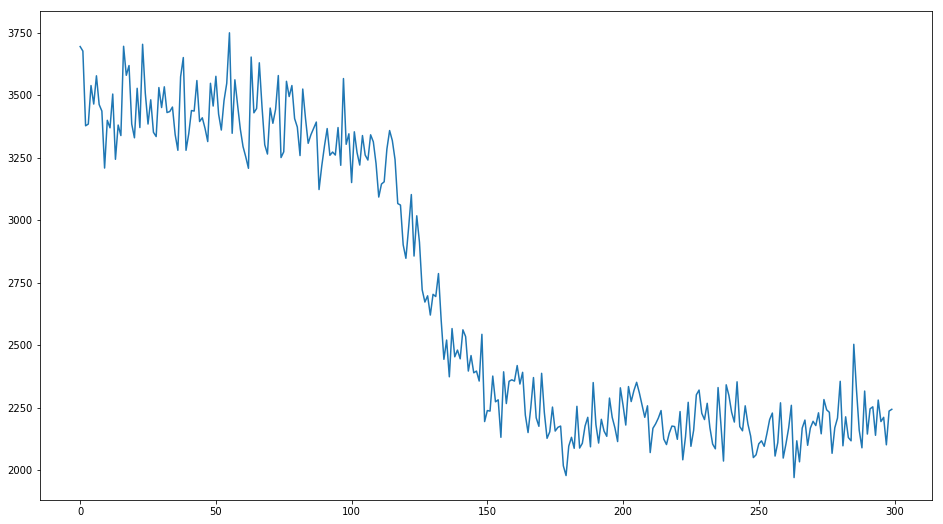

In [532]:
x = [it["iter_num"] for it in history[2]]
y = [it["best_makespan"] for it in history[2]]

plt.figure(figsize=(16, 9))
plt.plot(x, y)

In [533]:
 history[0]

1971